<a href="https://colab.research.google.com/github/tawiahnyt/sales-forecasting/blob/main/Synthetic_beverage_sales_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [68]:
!pip install xgboost
!pip install statsmodels
!pip install tensorflow

In [69]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning models & preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Deep learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Time series models
from statsmodels.tsa.arima.model import ARIMA

In [70]:
# Load the dataset again in case it's not yet loaded in this environment
data_path = "ultimate_data.csv"
df = pd.read_csv(data_path)

# Convert 'Date' to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [71]:
# check for missing values
df.isnull().sum()

,0
Order_ID,0
Customer_ID,0
Customer_Type,0
Product,0
Category,0
Quantity,0
Region,0
Order_Date,0
SKU,0
Volume,0


In [72]:
df.describe()

,Quantity,Order_Date,SKU,Volume
count,19998.000000,19998,19998.000000,19998.000000
mean,22.917192,2022-07-01 14:28:02.808280832,174.843684,3974.214271
min,1.000000,2021-01-01 00:00:00,0.000000,0.000000
25%,6.000000,2021-10-02 00:00:00,87.000000,606.000000
50%,11.000000,2022-07-02 00:00:00,176.000000,1685.000000
75%,29.000000,2023-04-01 00:00:00,262.000000,3948.000000
max,100.000000,2023-12-30 00:00:00,350.000000,34452.000000
std,26.797102,NaN,101.276284,5832.489569


In [73]:
df.describe(include='object')

,Order_ID,Customer_ID,Customer_Type,Product,Category,Region
count,19998,19998,19998,19998,19998,19998
unique,19936,8622,2,98,5,8
top,ORD738352,CUS449,B2C,BalonaAnyFlavour20GSht,Milk Powder,Eastern
freq,2,10,12928,296,4122,2585


In [74]:
df.shape

(19998, 10)

# Data Visualization

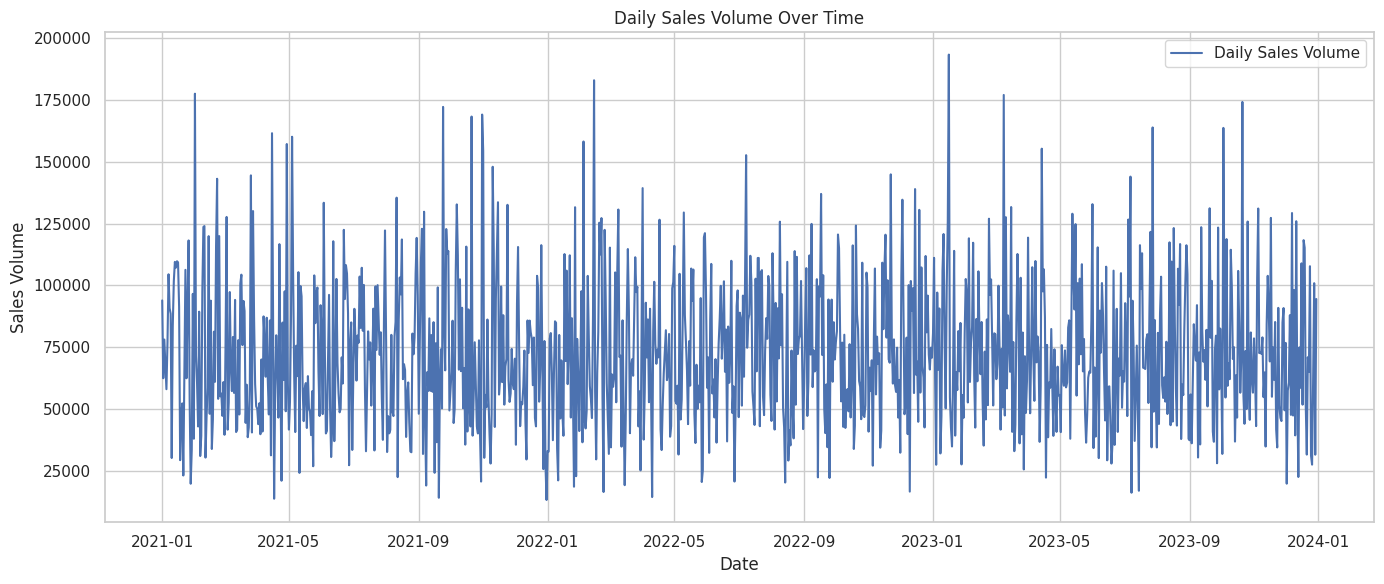

In [75]:
df = df.sort_values('Order_Date')

# Optionally aggregate by day if needed
daily_volume = df.groupby('Order_Date')['Volume'].sum().asfreq('D')

# Set plotting style
sns.set(style="whitegrid")



# Plot daily sales volume
plt.figure(figsize=(14, 6))
plt.plot(daily_volume, label='Daily Sales Volume')
plt.title('Daily Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

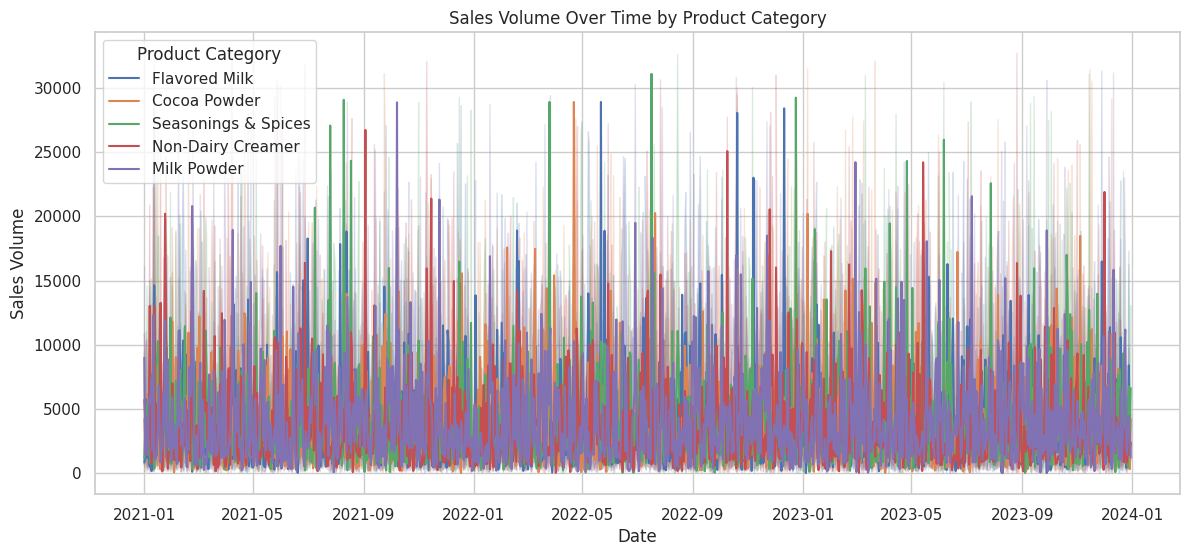

In [76]:
# Plot sales volume over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Order_Date', y='Volume', hue='Category')
plt.title('Sales Volume Over Time by Product Category')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend(title='Product Category')
plt.show()

<ipython-input-77-092023971cb4>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Order_Date', freq='M'))['Volume'].sum().reset_index()
<ipython-input-77-092023971cb4>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = monthly_sales.asfreq('M')


<Axes: title={'center': 'Monthly Sales Over Time (Volume in Million)'}, xlabel='Date', ylabel='Sales Volume (Millions)'>

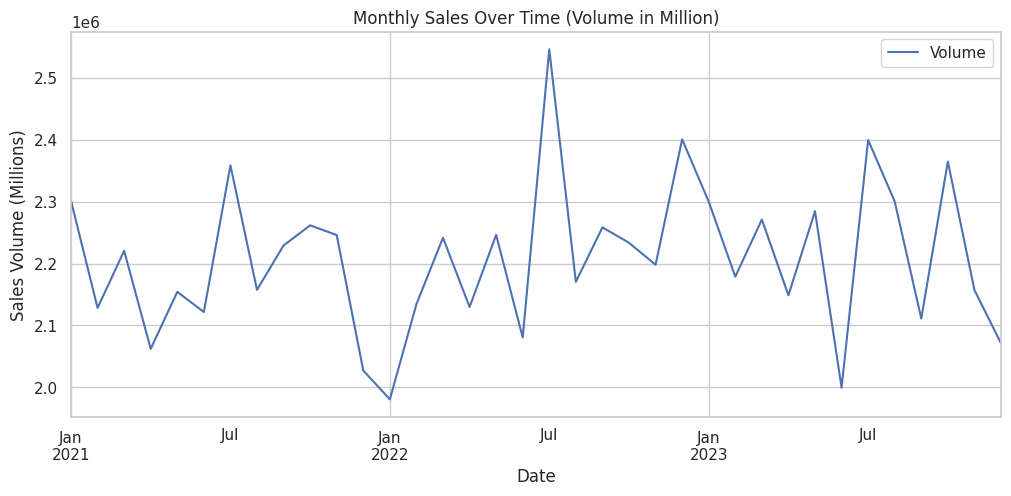

In [77]:
# Ensure date column is datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Aggregate monthly sales for all products
monthly_sales = df.groupby(pd.Grouper(key='Order_Date', freq='M'))['Volume'].sum().reset_index()

# Set date as index
monthly_sales.set_index('Order_Date', inplace=True)
monthly_sales = monthly_sales.asfreq('M')

monthly_sales.plot(title='Monthly Sales Over Time (Volume in Million)', figsize=(12,5), xlabel='Date', ylabel='Sales Volume (Millions)')

# Model Building

In [78]:
# Creating holders to store the model performance results
ML_Model = []
MSE = []
MAE = []
R2 = []

#function to call for storing the results
def storeResults(model, a,b,c):
  ML_Model.append(model)
  MSE.append(round(a, 3))
  MAE.append(round(b, 3))
  R2.append(round(c, 3))

## ARIMA Model

The formula for the ARIMA(p, d, q) model is:

$$(1 - \sum_{i=1}^{p} \phi_i L^i)(1-L)^d Y_t = (1 + \sum_{j=1}^{q} \theta_j L^j) \epsilon_t$$

Where:
- $Y_t$ is the time series value at time $t$.
- $p$ is the order of the Autoregressive (AR) part.
- $d$ is the order of the Integrated (I) part (the number of nonseasonal differences).
- $q$ is the order of the Moving Average (MA) part.
- $L$ is the lag operator, such that $L^k Y_t = Y_{t-k}$.
- $\phi_i$ are the parameters of the AR part.
- $\theta_j$ are the parameters of the MA part.
- $\epsilon_t$ is the error term (white noise) at time $t$.

Breaking down the components:
- **AR(p):** The current value of the time series is a linear combination of the past $p$ values.
- **I(d):** The time series is differenced $d$ times to make it stationary.
- **MA(q):** The current value of the time series is a linear combination of the past $q$ error terms.

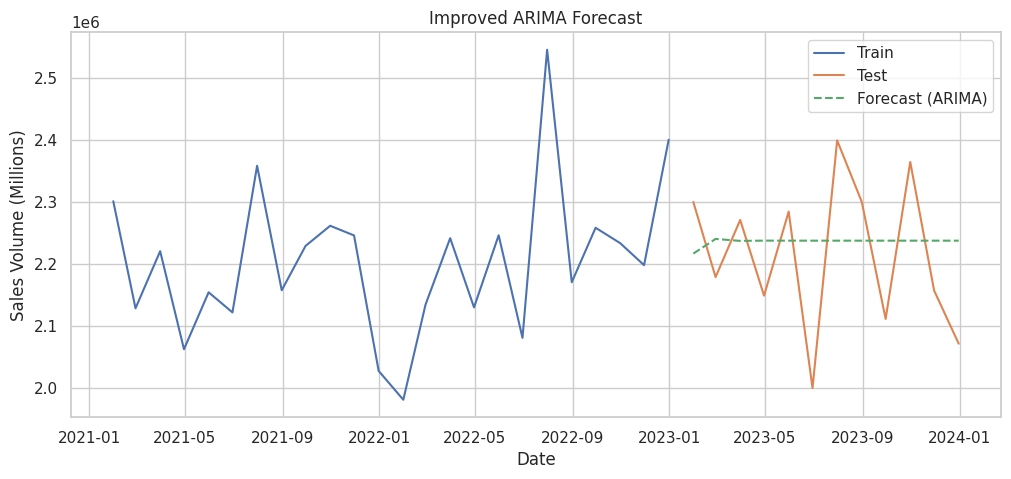

Improved ARIMA - MSE: 14598364750.28, MAE: 106488.22, R²: -0.06 


In [79]:
from statsmodels.tsa.arima.model import ARIMA
train = monthly_sales[:-12]  # All data except the last 12 months for training
test = monthly_sales[-12:]   # Last 12 months for testing


# Log transform
train_log = np.log(train['Volume'])

# Fit ARIMA
model = ARIMA(train_log, order=(1,1,1))
model_fit = model.fit()

# Forecast and revert transformation
forecast_log = model_fit.forecast(steps=12)
forecast = np.exp(forecast_log)
forecast.index = test.index

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Volume'], label='Train')
plt.plot(test.index, test['Volume'], label='Test')
plt.plot(test.index, forecast, label='Forecast (ARIMA)', linestyle='--')
plt.legend()
plt.title('Improved ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

# Metrics
y_true = test['Volume'].values
c = forecast.values
mse = mean_squared_error(y_true, c)
mae = mean_absolute_error(y_true, c)
r2 = r2_score(y_true, c)
# accuracy = accuracy_score(y_true, c)
# recall = recall_score(y_true, c, average='weighted')
# f1 = f1_score(y_true, c, average='weighted')
# precision = precision_score(y_true, c, average='weighted')

print(f"Improved ARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f} ")
storeResults('ARIMA', mse, mae, r2)

In [80]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# # Train-test split
# train = monthly_sales.iloc[:-12]
# test = monthly_sales.iloc[-12:]

# # Fit ARIMA model (simple auto config)
# model = ARIMA(train, order=(1,1,1))
# model_fit = model.fit()

# # Forecast
# forecast = model_fit.forecast(steps=12)

# # Plot
# plt.figure(figsize=(12,5))
# plt.plot(train, label='Train')
# plt.plot(test, label='Test')
# plt.plot(forecast, label='Forecast (ARIMA)', linestyle='--')
# plt.legend()
# plt.title('ARIMA Forecast')
# plt.xlabel('Date')
# plt.ylabel('Sales Volume (Millions)')
# plt.show()


In [81]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Convert to numpy for metrics
# y_true_arima = test['Volume'].values
# y_pred_arima = forecast.values

# # ARIMA metrics
# mse_arima = mean_squared_error(y_true_arima, y_pred_arima)
# mae_arima = mean_absolute_error(y_true_arima, y_pred_arima)
# r2_arima = r2_score(y_true_arima, y_pred_arima)

# print(f"ARIMA - MSE: {mse_arima:.2f}, MAE: {mae_arima:.2f}, R²: {r2_arima:.2f}")

## XGBoost Model

The objective function for XGBoost is a sum of a differentiable loss function and an L1/L2 regularization term for each tree. At the $t$-th iteration, XGBoost adds a new tree $f_t$ to minimize the following objective function:

$$ \mathcal{O}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + C $$

Where:
- $l(y_i, \hat{y}_i^{(t)})$ is a differentiable loss function that measures the difference between the true label $y_i$ and the prediction $\hat{y}_i^{(t)}$ for data point $i$. $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ is the prediction at the $t$-th iteration.
- $\Omega(f_t)$ is the regularization term for the $t$-th tree $f_t$. It is defined as:
  $$ \Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2 $$
  Where $T$ is the number of leaves in the tree, $w_j$ is the score (output value) of the $j$-th leaf, $\gamma$ is the penalty for the number of leaves, and $\lambda$ is the L2 regularization weight on the leaf scores.
- $C$ is a constant term representing the sum of regularization terms for the first $t-1$ trees, which is not dependent on $f_t$.

To minimize this objective function effectively, XGBoost uses a second-order Taylor expansion of the loss function around the current prediction $\hat{y}_i^{(t-1)}$:

$$ \mathcal{O}^{(t)} \approx \sum_{i=1}^n \left[ l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right] + \Omega(f_t) + C $$

Where $g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}$ is the first-order gradient and $h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}$ is the second-order gradient of the loss function with respect to the prediction at the previous iteration.

By removing the constant terms $l(y_i, \hat{y}_i^{(t-1)})$ and $C$, the simplified objective function for finding the optimal $f_t$ at step $t$ becomes:

$$ \mathcal{O}^{(t)} \approx \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right] + \Omega(f_t) $$

If we define the structure of the tree $f_t$ by mapping each data point $x_i$ to a leaf $q(x_i)$, and assign a weight $w_{q(x_i)}$ to that leaf, then $f_t(x_i) = w_{q(x_i)}$. Substituting this into the objective and rearranging by leaves, the objective becomes:

$$ \mathcal{O}^{(t)} \approx \sum_{j=1}^T \left[ \left( \sum_{i \in I_j} g_i \right) w_j + \frac{1}{2} \left( \sum_{i \in I_j} h_i + \lambda \right) w_j^2 \right] + \gamma T $$

Where $I_j = \{i \mid q(x_i) = j\}$ is the set of indices of data points mapped to leaf $j$.

Let $G_j = \sum_{i \in I_j} g_i$ and $H_j = \sum_{i \in I_j} h_i$. The objective for a fixed tree structure can be written as:

$$ \mathcal{O}^{(t)} \approx \sum_{j=1}^T \left[ G_j w_j + \frac{1}{2} (H_j + \lambda) w_j^2 \right] + \gamma T $$

For a fixed tree structure, the optimal weight $w_j^*$ for leaf $j$ is found by setting the first derivative with respect to $w_j$ to zero:

$$ G_j + (H_j + \lambda) w_j = 0 $$
$$ w_j^* = -\frac{G_j}{H_j + \lambda} $$

Substituting the optimal weights $w_j^*$ back into the objective function gives the optimal objective value for a fixed tree structure:

$$ \mathcal{O}^{(t)}(q) = -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j + \lambda} + \gamma T $$

This value represents the "structure score" of the tree. XGBoost greedily builds the tree by trying to maximize the gain from splitting a node. The gain from splitting a node into left ($I_L$) and right ($I_R$) children is calculated as:

$$ Gain = \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L+G_R)^2}{H_L+H_R+\lambda} - \gamma $$

Where $G_L, H_L$ are the sums of gradients and hessians for the left child nodes, $G_R, H_R$ for the right child nodes, and $G_L+G_R, H_L+H_R$ for the original parent node. A split is performed only if the gain is positive.

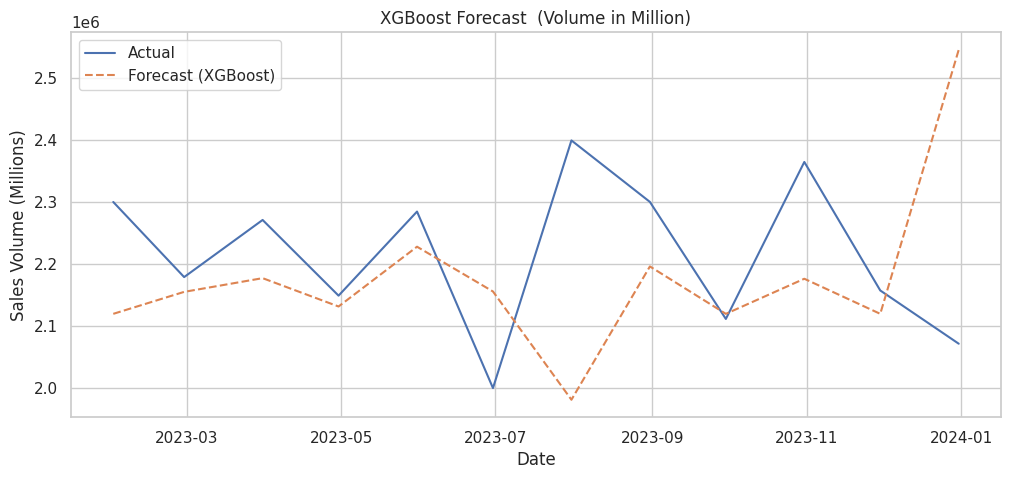

XGBoost Performance:
MSE: 43237552128.00, MAE: 146797.92, R²: -2.13


In [82]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Create lag features
df_lag = monthly_sales.copy()
for lag in range(1, 13):
    df_lag[f'lag_{lag}'] = df_lag['Volume'].shift(lag)
df_lag.dropna(inplace=True)

# Split data
X = df_lag.drop(columns='Volume')
y = df_lag['Volume']

X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

# Fit XGBoost
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# Predict
preds = model_xgb.predict(X_test)

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.title('XGBoost Forecast  (Volume in Million)')
plt.show()

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("XGBoost Performance:")
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
storeResults('XGBoost', mse, mae, r2)


## LSTM

The core of an LSTM (Long Short-Term Memory) network is its **cell state** and various **gates** that regulate the flow of information into and out of the cell state. The gates are typically implemented using sigmoid neural networks and pointwise multiplication.

Here are the main components and formulas for a standard LSTM unit at time step $t$:

1.  **Forget Gate ($f_t$):** This gate decides what information to throw away from the cell state. It looks at the previous hidden state $h_{t-1}$ and the current input $x_t$, and outputs a number between 0 and 1 for each number in the cell state $C_{t-1}$. A 1 means "keep this completely," while a 0 means "throw this away completely."

    $$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

    Where:
    *   $\sigma$ is the sigmoid function.
    *   $W_f$ is the weight matrix for the forget gate.
    *   $b_f$ is the bias vector for the forget gate.
    *   $[h_{t-1}, x_t]$ is the concatenation of the previous hidden state and the current input.

2.  **Input Gate ($i_t$) and Candidate Cell State ($\tilde{C}_t$):** This step decides what new information to store in the cell state. It consists of two parts:
    *   The **input gate layer** ($i_t$) decides which values to update. This is a sigmoid layer.
        $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
    *   The **tanh layer** ($\tilde{C}_t$) creates a vector of new candidate values that could be added to the state.
        $$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

    Where:
    *   $W_i, W_C$ are the weight matrices for the input gate and candidate cell state respectively.
    *   $b_i, b_C$ are the bias vectors.
    *   $\tanh$ is the hyperbolic tangent function.

3.  **Update Cell State ($C_t$):** This is where the old cell state $C_{t-1}$ is updated into the new cell state $C_t$. We multiply the old state by $f_t$ (forgetting the things we decided to forget) and then add $i_t * \tilde{C}_t$ (adding the new candidate values, scaled by how much we decided to update each value).

    $$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

4.  **Output Gate ($o_t$) and Hidden State ($h_t$):** This step decides what to output.
    *   The **output gate layer** ($o_t$) is a sigmoid layer that decides which parts of the cell state to output.
        $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
    *   We then put the cell state through $\tanh$ (to push the values between -1 and 1) and multiply it by the output of the sigmoid gate ($o_t$) to get the hidden state $h_t$. The hidden state is the output of the LSTM unit for this time step.
        $$h_t = o_t * \tanh(C_t)$$

    Where:
    *   $W_o$ is the weight matrix for the output gate.
    *   $b_o$ is the bias vector.

These formulas describe how an LSTM unit processes sequential data, selectively remembering or forgetting information through its gating mechanisms.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
LSTM Performance:
MSE: 14861116634.48, MAE: 106146.21, R²: -0.07


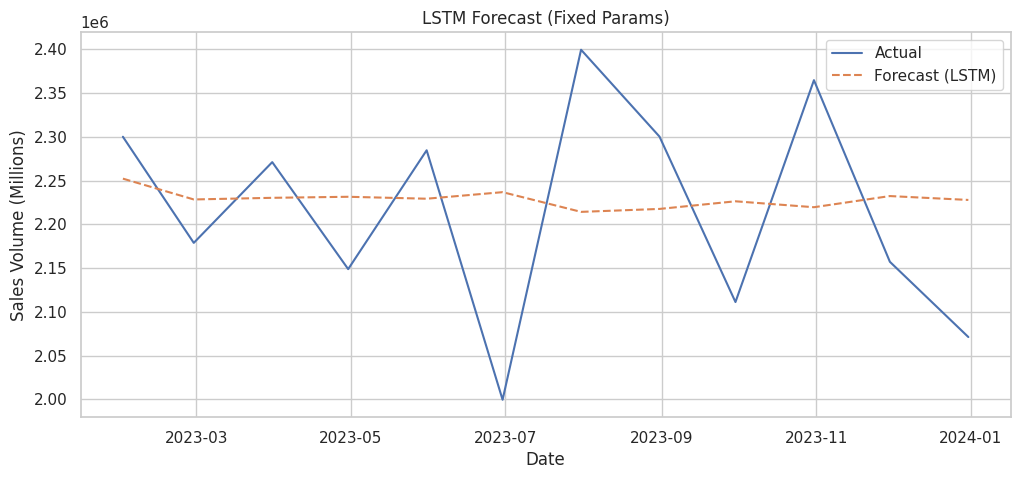

In [83]:
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fix randomness
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_sales)

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Parameters
seq_len = 6
units = 100
epochs = 100

# Prepare data
X, y = create_sequences(scaled_data, seq_len)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model = Sequential([
    LSTM(units, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Predict
pred_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Metrics
mse = mean_squared_error(y_true, pred_lstm)
mae = mean_absolute_error(y_true, pred_lstm)
r2 = r2_score(y_true, pred_lstm)

print(f"LSTM Performance:")
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index[-12:], monthly_sales.values[-12:], label='Actual')
plt.plot(monthly_sales.index[-12:], pred_lstm, label='Forecast (LSTM)', linestyle='--')
plt.legend()
plt.title('LSTM Forecast (Fixed Params)')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

storeResults('LSTM', mse, mae, r2)

# Feature Engineering (for XGBoost and LSTM)

In [84]:
# Reset index to access Date parts
df_feat = monthly_sales.copy().reset_index()

# Date-based features
df_feat['month'] = df_feat['Order_Date'].dt.month
df_feat['quarter'] = df_feat['Order_Date'].dt.quarter
df_feat['year'] = df_feat['Order_Date'].dt.year
df_feat['is_month_start'] = df_feat['Order_Date'].dt.is_month_start.astype(int)
df_feat['is_month_end'] = df_feat['Order_Date'].dt.is_month_end.astype(int)

# Rolling features
df_feat['rolling_mean_3'] = df_feat['Volume'].rolling(3).mean()
df_feat['rolling_std_3'] = df_feat['Volume'].rolling(3).std()
df_feat['rolling_mean_6'] = df_feat['Volume'].rolling(6).mean()
df_feat['rolling_std_6'] = df_feat['Volume'].rolling(6).std()

# Lag features (same as before)
for lag in range(1, 13):
    df_feat[f'lag_{lag}'] = df_feat['Volume'].shift(lag)

# Drop NA
df_feat.dropna(inplace=True)

# Final dataset
X = df_feat.drop(columns=['Order_Date', 'Volume'])
y = df_feat['Volume']


## XGBoost

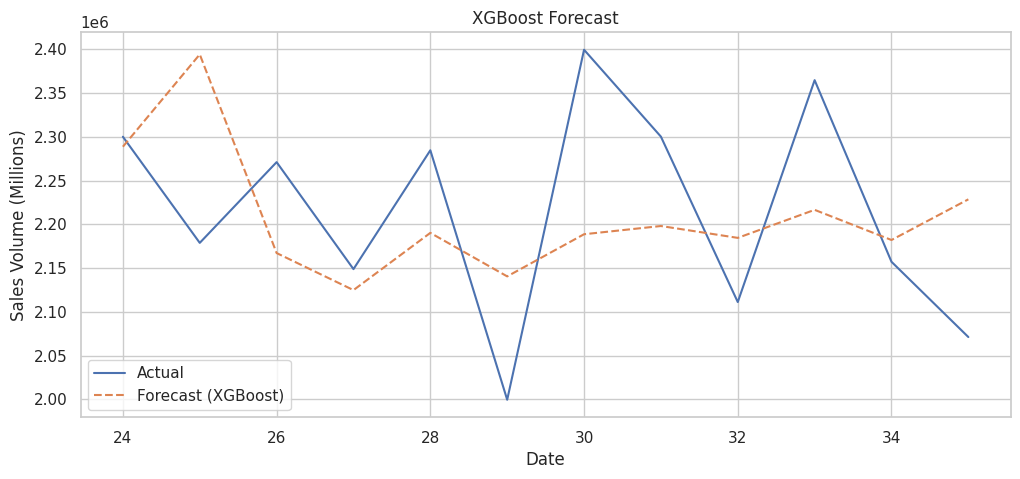

XGBoost RMSE: 127262.96605061505


In [85]:
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)


# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


In [86]:
# XGBoost metrics
mse_xgb = mean_squared_error(y_test, preds)
mae_xgb = mean_absolute_error(y_test, preds)
r2_xgb = r2_score(y_test, preds)

print(f"XGBoost - MSE: {mse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")
storeResults('XGBoost (Feature Engineering)', mse_xgb, mae_xgb, r2_xgb)

XGBoost - MSE: 16195862528.00, MAE: 108918.09, R²: -0.17


## LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


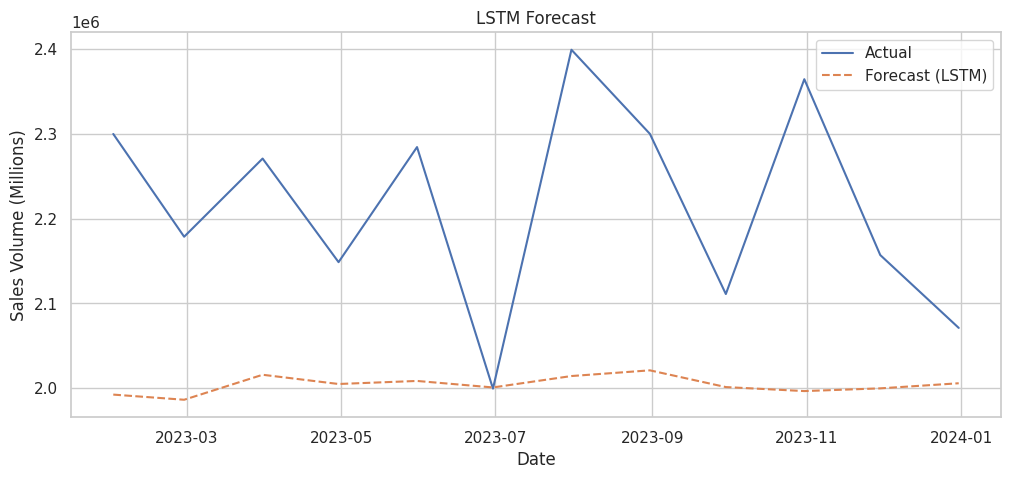

In [87]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# ... (your existing code for data loading and feature engineering) ...

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences
def create_sequences_lstm(X, y, seq_len=12):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences_lstm(X_scaled, y_scaled)

# Train-test split
X_train_lstm, X_test_lstm = X_lstm[:-12], X_lstm[-12:]
y_train_lstm, y_test_lstm = y_lstm[:-12], y_lstm[-12:]

# Build LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, verbose=0)

# Predict
pred_scaled = model_lstm.predict(X_test_lstm)
pred_lstm1 = scaler_y.inverse_transform(pred_scaled)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index[-12:], monthly_sales.values[-12:], label='Actual')
plt.plot(monthly_sales.index[-12:], pred_lstm1, label='Forecast (LSTM)', linestyle='--')
plt.legend()
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()


In [88]:
print(f"LSTM Tuned - MSE: {mean_squared_error(y_test_lstm, pred_lstm1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_lstm, pred_lstm1):.2f}, "
      f"R²: {r2_score(y_test_lstm, pred_lstm1):.2f}")

storeResults('LSTM (Feature Engineering)', mean_squared_error(y_test_lstm, pred_lstm1),
             mean_absolute_error(y_test_lstm, pred_lstm1), r2_score(y_test_lstm, pred_lstm1))

LSTM Tuned - MSE: 4016067514882.16, MAE: 2003990.01, R²: -92842270063209.95


## Hyperparameter Tuning for XGBoost using GridSearchCV

In [89]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV

# Perform grid search
grid_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                                    scoring='neg_mean_squared_error', n_iter=30, cv=3,
                                    verbose=1, n_jobs=-1, random_state=42)

grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
xgb_preds_tuned = best_xgb.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"XGBoost Tuned - MSE: {mean_squared_error(y_test, xgb_preds_tuned):.2f}, MAE: {mean_absolute_error(y_test, xgb_preds_tuned):.2f}, R²: {r2_score(y_test, xgb_preds_tuned):.2f}")

storeResults('XGBoost (Tuned)', mean_squared_error(y_test, xgb_preds_tuned), mean_absolute_error(y_test, xgb_preds_tuned), r2_score(y_test, xgb_preds_tuned))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBoost Tuned - MSE: 15155885056.00, MAE: 110163.25, R²: -0.10


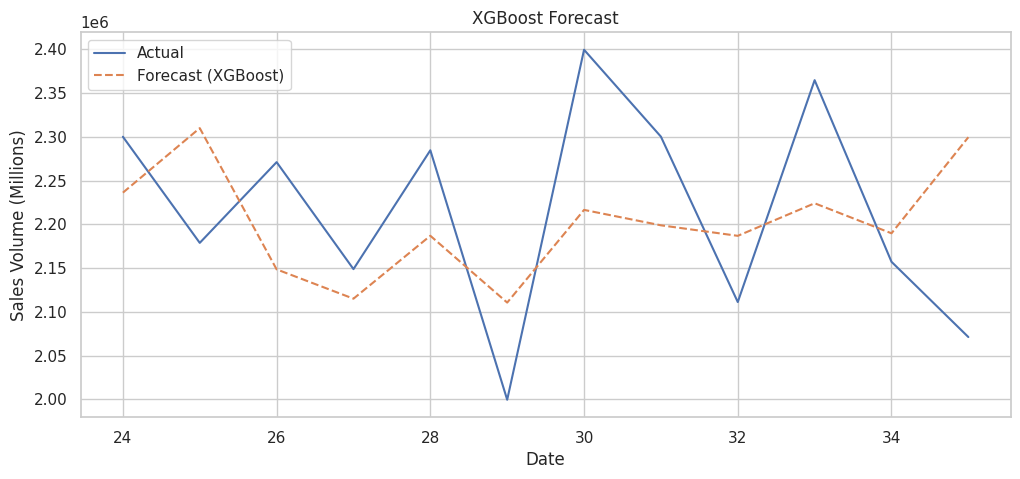

In [90]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_preds_tuned, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

## Improve XGBoost Tuning with RandomizedSearchCV

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Random search setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
random_search.fit(X_train, y_train)

# Best tuned model
best_xgb_tuned = random_search.best_estimator_

# Predict and evaluate
xgb_preds_best = best_xgb_tuned.predict(X_test)

print(f"\n📊 XGBoost (Random Search)")
print(f"MSE : {mean_squared_error(y_test, xgb_preds_best):.2f}")
print(f"MAE : {mean_absolute_error(y_test, xgb_preds_best):.2f}")
print(f"R²  : {r2_score(y_test, xgb_preds_best):.2f}")

# Display best parameters
print("\nBest Parameters:")
print(random_search.best_params_)

# {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

# {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}



Fitting 3 folds for each of 30 candidates, totalling 90 fits

📊 XGBoost (Random Search)
MSE : 15937683456.00
MAE : 112376.77
R²  : -0.15

Best Parameters:
{'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


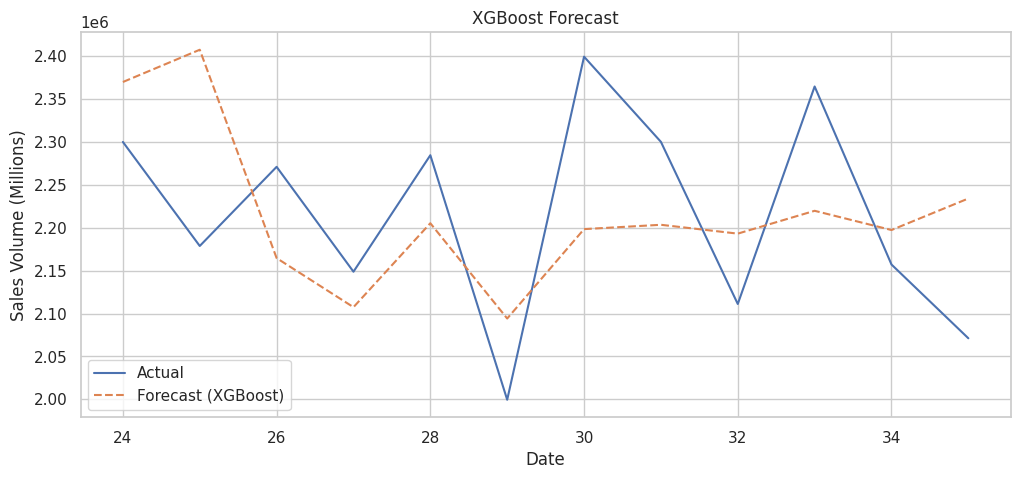

In [92]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_preds_best, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

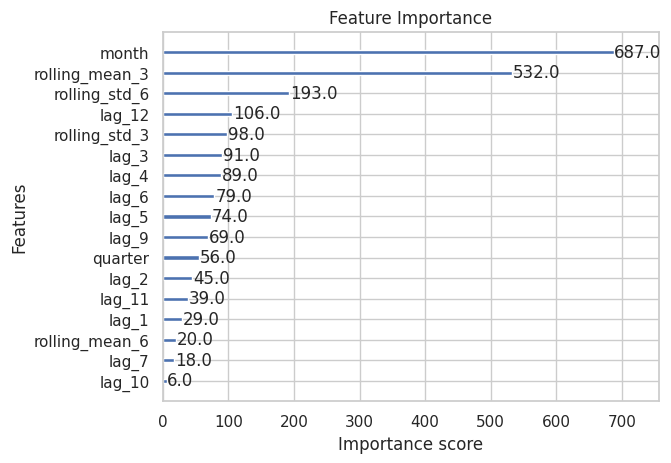

In [93]:
xgb.plot_importance(best_xgb_tuned)
plt.title("Feature Importance")
plt.show()


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

# Manually specified best parameters
manual_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.6
}

# Create and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **manual_params)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
preds = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Output evaluation
print(f"\n📊 XGBoost (Manual Params)")
print(f"RMSE : {np.sqrt(mse):.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.2f}")
print(f"Params used: {manual_params}")

storeResults('XGBoost (Imporved)', mse, mae, r2)


📊 XGBoost (Manual Params)
RMSE : 101458.64
MAE  : 81660.91
R²   : 0.26
Params used: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.5, 'subsample': 0.8, 'colsample_bytree': 0.6}


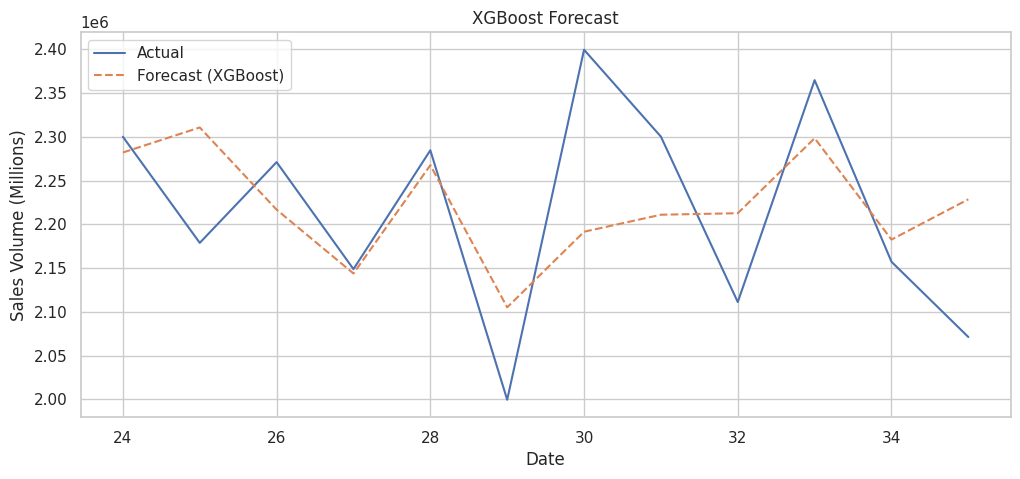

In [95]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

# Model Stacking

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare the stacked features (predictions from ARIMA, XGBoost, LSTM)
# X_stack = np.column_stack([y_pred_arima, preds, pred_lstm])
X_stack = np.column_stack([c, preds, pred_lstm])

# Train a meta-learner (Linear Regression in this case)
meta_model = LinearRegression()
meta_model.fit(X_stack, y_test)  # Train on the stacked predictions

# Make predictions with the meta-model
stacked_preds = meta_model.predict(X_stack)

# Evaluate the stacked model
print("\n📊 Stacked Model Performance")
print("----------------------------")
print("Stacked MSE:", mean_squared_error(y_test, stacked_preds))
print("Stacked MAE:", mean_absolute_error(y_test, stacked_preds))
print("Stacked R²:", r2_score(y_test, stacked_preds))


storeResults('Stacked Model', mean_squared_error(y_test, stacked_preds), mean_absolute_error(y_test, stacked_preds), r2_score(y_test, stacked_preds))



📊 Stacked Model Performance
----------------------------
Stacked MSE: 4162384889.7151895
Stacked MAE: 50706.26024554856
Stacked R²: 0.6989789397060229


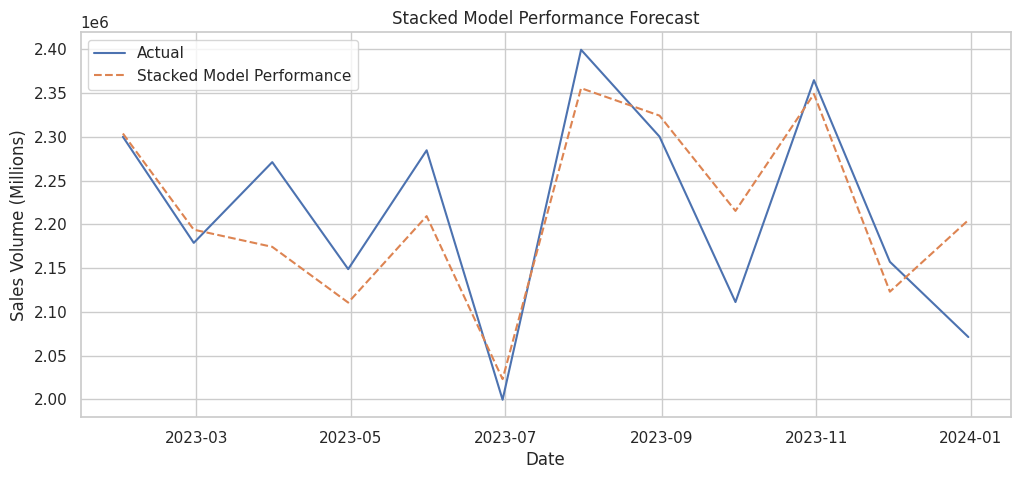

In [97]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(monthly_sales.index[-12:], y_test, label='Actual') # Use monthly_sales.index[-12:] for time index
plt.plot(monthly_sales.index[-12:], stacked_preds, label='Stacked Model Performance', linestyle='--')
plt.legend()
plt.title('Stacked Model Performance Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

In [108]:
#creating dataframe
# Format each metric value as a string with two decimal places
formatted_mse = [f'{m:.3f}' for m in MSE]
formatted_mae = [f'{m:.3f}' for m in MAE]
formatted_r2 = [f'{m:.3f}' for m in R2]


result = pd.DataFrame({ 'Models' : ML_Model,
                        'Mean Squared Error' : formatted_mse, # Use the formatted list
                        'Mean Absolute Error' : formatted_mae, # Use the formatted list
                        'R2 Score' : formatted_r2 # Use the formatted list
                      })

In [109]:
result

,Models,Mean Squared Error,Mean Absolute Error,R2 Score
0,ARIMA,14598364750.281,106488.220,-0.056
1,XGBoost,43237552128.000,146797.922,-2.127
2,LSTM,14861116634.479,106146.208,-0.075
3,XGBoost (Feature Engineering),16195862528.000,108918.086,-0.171
4,LSTM (Feature Engineering),4016067514882.156,2003990.012,-92842270063209.953
5,XGBoost (Tuned),15155885056.000,110163.250,-0.096
6,XGBoost (Imporved),10293855232.000,81660.914,0.256
7,Stacked Model,4162384889.715,50706.260,0.699


In [111]:
#Sorting the datafram on R2
sorted_result=result.sort_values(by=['R2 Score'],ascending=False).reset_index(drop=True)

In [112]:
sorted_result

,Models,Mean Squared Error,Mean Absolute Error,R2 Score
0,Stacked Model,4162384889.715,50706.260,0.699
1,XGBoost (Imporved),10293855232.000,81660.914,0.256
2,LSTM (Feature Engineering),4016067514882.156,2003990.012,-92842270063209.953
3,XGBoost,43237552128.000,146797.922,-2.127
4,XGBoost (Feature Engineering),16195862528.000,108918.086,-0.171
5,XGBoost (Tuned),15155885056.000,110163.250,-0.096
6,LSTM,14861116634.479,106146.208,-0.075
7,ARIMA,14598364750.281,106488.220,-0.056


# Generate Future Forecasts

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


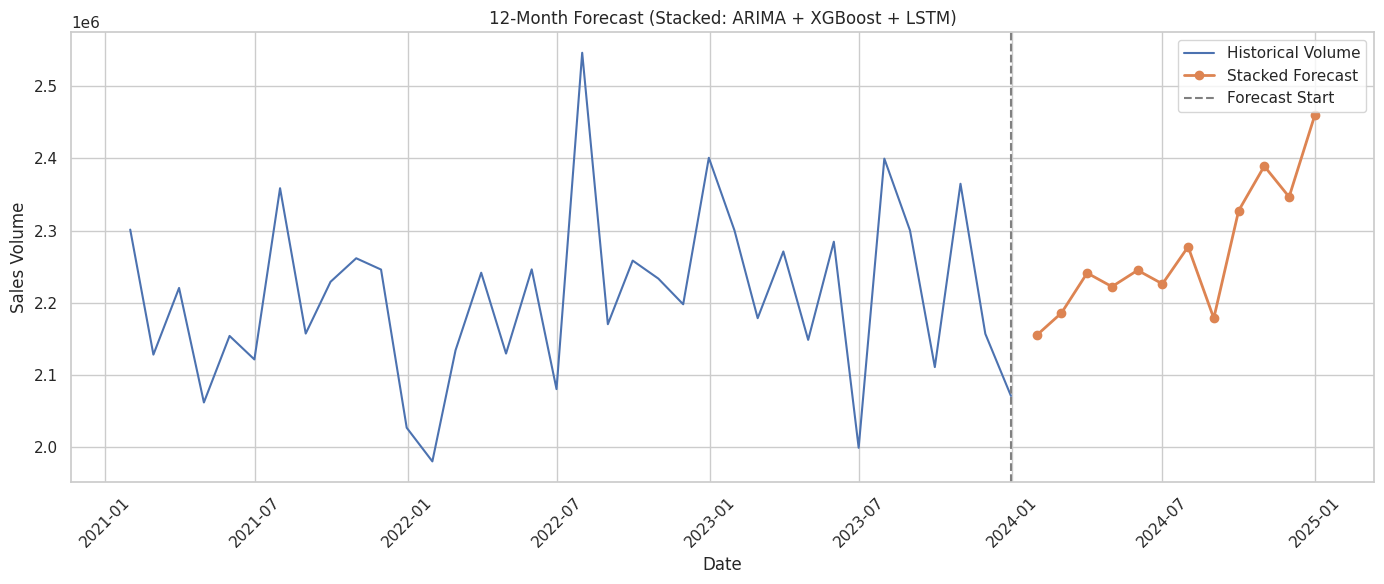

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense

# === STEP 1: Prepare Univariate LSTM Data ===
data = monthly_sales[['Volume']].values
scaler_uni = MinMaxScaler()
data_scaled = scaler_uni.fit_transform(data)

timesteps = 12
X_uni, y_uni = [], []
for i in range(timesteps, len(data_scaled)):
    X_uni.append(data_scaled[i-timesteps:i])
    y_uni.append(data_scaled[i])
X_uni, y_uni = np.array(X_uni), np.array(y_uni)

# === STEP 2: Train LSTM ===
model_lstm_uni = Sequential()
model_lstm_uni.add(LSTM(units=50, activation='relu', input_shape=(X_uni.shape[1], 1)))
model_lstm_uni.add(Dense(1))
model_lstm_uni.compile(optimizer='adam', loss='mse')
model_lstm_uni.fit(X_uni, y_uni, epochs=30, verbose=0)

# === STEP 3: LSTM Forecast for Past 12 (for stacking training) ===
X_last12 = X_uni[-12:]
pred_lstm_scaled_train = model_lstm_uni.predict(X_last12, verbose=0)
pred_lstm_train = scaler_uni.inverse_transform(pred_lstm_scaled_train).flatten()

# === STEP 4: ARIMA and XGBoost Forecasts for Past 12 ===
arima_fitted_values = model_fit.fittedvalues[-12:].values
xgb_pred_train = model_xgb.predict(df_feat.drop(columns=['Order_Date', 'Volume'], errors='ignore')).flatten()
xgb_pred_train = xgb_pred_train[-12:]

# === STEP 5: Train Meta-Model ===
stacked_X_train = np.column_stack([arima_fitted_values, xgb_pred_train, pred_lstm_train])
stacked_y_train = monthly_sales['Volume'].values[-12:]

scaler_meta = StandardScaler()
stacked_X_train_scaled = scaler_meta.fit_transform(stacked_X_train)

meta_model = LinearRegression()
meta_model.fit(stacked_X_train_scaled, stacked_y_train)

# === STEP 6: Forecast Next 12 Using Base Models ===

## ARIMA future
future_arima = model_fit.forecast(steps=12)

## XGBoost future
future_xgb = []
latest_features = df_feat.iloc[-1:].copy()
for _ in range(12):
    X_future = latest_features.drop(columns=['Order_Date', 'Volume'], errors='ignore')
    pred = model_xgb.predict(X_future)[0]
    future_xgb.append(pred)

    for lag in range(12, 1, -1):
        latest_features[f'lag_{lag}'] = latest_features[f'lag_{lag - 1}']
    latest_features['lag_1'] = pred
    latest_features['rolling_mean_3'] = np.mean([latest_features[f'lag_{i}'] for i in range(1, 4)])
    latest_features['rolling_mean_6'] = np.mean([latest_features[f'lag_{i}'] for i in range(1, 7)])
    latest_features['rolling_std_3'] = np.std([latest_features[f'lag_{i}'] for i in range(1, 4)])
    latest_features['rolling_std_6'] = np.std([latest_features[f'lag_{i}'] for i in range(1, 7)])

## LSTM future
lstm_input = X_uni[-1:]
future_lstm = []
for _ in range(12):
    pred_scaled = model_lstm_uni.predict(lstm_input, verbose=0)
    pred_unscaled = scaler_uni.inverse_transform(pred_scaled)[0][0]
    future_lstm.append(pred_unscaled)

    new_input = pred_scaled.reshape(1, 1, 1)
    lstm_input = np.concatenate([lstm_input[:, 1:, :], new_input], axis=1)

# === STEP 7: Stacked Forecast ===
stacked_X_future = np.column_stack([future_arima, future_xgb, future_lstm])
stacked_X_future_scaled = scaler_meta.transform(stacked_X_future)
stacked_forecast = meta_model.predict(stacked_X_future_scaled)

# === STEP 8: Plot ===
last_date = monthly_sales.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index, monthly_sales['Volume'], label='Historical Volume')
plt.plot(future_dates, stacked_forecast, label='Stacked Forecast', marker='o', linewidth=2)
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("12-Month Forecast (Stacked: ARIMA + XGBoost + LSTM)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Synthetic Time Series Data




<Axes: title={'center': 'Synthetic Sales Volume (Trend + Seasonality + Noise)'}, xlabel='Date'>

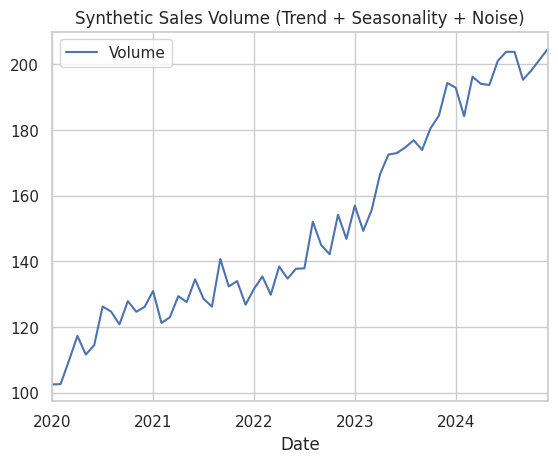

In [101]:
import pandas as pd
import numpy as np

def generate_synthetic_series(start='2020-01-01', periods=60, freq='MS'):
    np.random.seed(42)
    date_range = pd.date_range(start=start, periods=periods, freq=freq)
    trend = np.linspace(100, 200, periods)
    seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, periods))
    noise = np.random.normal(scale=5, size=periods)
    volume = trend + seasonality + noise
    return pd.DataFrame({'Date': date_range, 'Volume': volume}).set_index('Date')

synthetic_data = generate_synthetic_series()

synthetic_data.plot(title="Synthetic Sales Volume (Trend + Seasonality + Noise)")


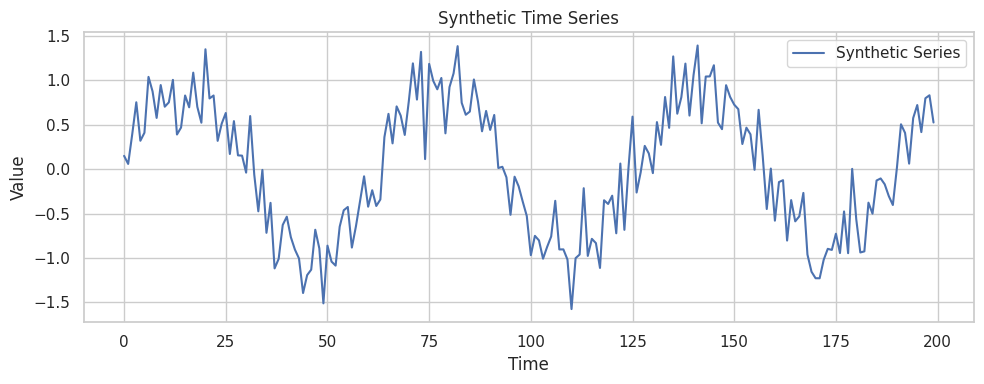

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Time vector
time = np.arange(0, 200)

# Synthetic time series: sine wave + noise
synthetic_series = np.sin(0.1 * time) + np.random.normal(scale=0.3, size=len(time))

# Plot it
plt.figure(figsize=(10, 4))
plt.plot(time, synthetic_series, label="Synthetic Series")
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
